In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import scipy.integrate as integrate
import GPy

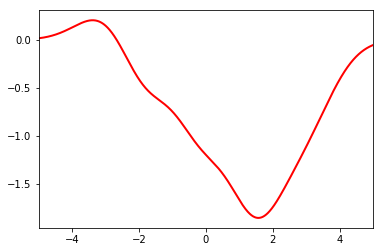

In [2]:
def sample_function(x_range, N=1000, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = GPy.kern.src.rbf.RBF(input_dim=dx,lengthscale=1.0)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
#     mean = gpy.mappings.Linear(dx, 1)
    mu = np.zeros(x.shape)
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    #import pdb; pdb.set_trace()
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.01

    def f(x): return m.predict(x)[0]
    return f
x_range = np.array([[-2.], [2.]])
f = sample_function(x_range)

def plot_f(f):
    xx = np.linspace(-5.0, 5.0, 1000).reshape(1000, 1)
    yy = f(xx)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(-5.0, 5.0)
    plt.show()
plot_f(f)

def plot(m, reff=None):
    xx = np.linspace(-5.0, 5.0, 300).reshape(300, 1)
    mean, std = m.predict(xx,return_std=True)
    mean = mean[:,0]
    plt.plot(xx, mean, 'r', lw=2,label='GP mean')
    plt.fill_between(xx[:, 0],
                     mean - std**2,
                     mean + std**2,
                     color='r', alpha=0.2,label='95% confidence interval')
    plt.xlim(-5.0, 5.0)
    if reff:
        xx = np.linspace(-5.0, 5.0, 1000).reshape(1000, 1)
        yy = reff(xx)
        plt.plot(xx, yy, 'b', lw=2,label='ground truth')
        plt.xlim(-5.0, 5.0)
    plt.legend(loc='upper left')
    plt.show()

In [3]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(3.0)).pdf(s)
print f(np.array([[0]]))
print "Mean Numerical Integration"
integral_value,_ = integrate.quad(lambda x: f(np.array([[x]]))*normal(x),np.NINF,np.inf)
print integral_value

[[-1.19887482]]
Mean Numerical Integration
-1.05621382608


In [4]:
def bintegrate(gp,b,B):
    n,dim = gp.X_train_.shape
    length_scale = gp.kernel_.length_scale
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X_train_
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = (z.T).dot(cho_solve((gp.L_, True), gp.y_train_))
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, cho_solve((gp.L_, True), z))
    return mean[0][0], var[0][0], z

def bacquistion(gp,xs,zprev):
    n,dim = gp.X_train_.shape
    length_scale = gp.kernel_.length_scale
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X_train_
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    variances = np.zeros((xs.shape[0]))
    
    for i in range(xs.shape[0]):
        x = xs[i, :]
        Xnew = np.vstack((gp.X_train_, x))
        K = gp.kernel_(Xnew)
        K[np.diag_indices_from(K)] += gp.alpha
        ztemp = determ * np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        ztemp = np.vstack((zprev, ztemp))
        L = cholesky(K, lower=True)
        Kz = cho_solve((L, True), ztemp)
        variances[i] = var_determ - np.dot(ztemp.T, Kz)
    sorted_vars = variances.argsort()
    return xs[sorted_vars[0]]

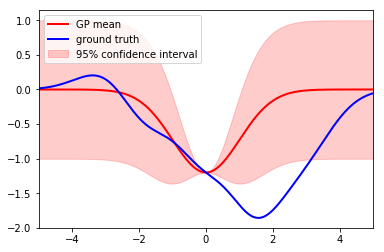

Mean: -0.5994374108898889 , Variance 0.1279644730342273
new sample[[1.86868687]]


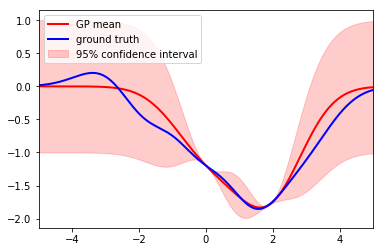

Mean: -0.9857148311804729 , Variance 0.0705626767135828
new sample[[-1.76767677]]


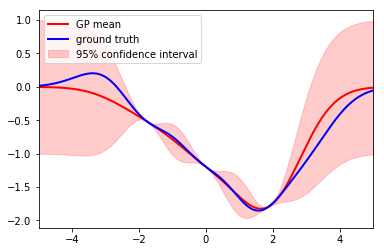

Mean: -1.0676059689113417 , Variance 0.0091833621838640
new sample[[-3.48484848]]


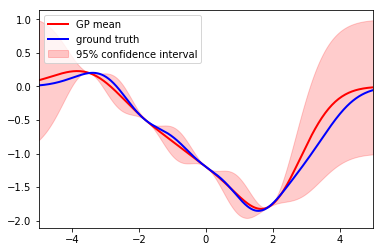

Mean: -1.0526186879040247 , Variance 0.0064751268874093
new sample[[3.68686869]]


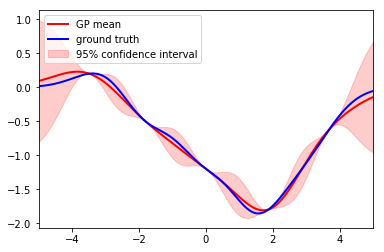

Mean: -1.0658490288264357 , Variance 0.0045806924961227
new sample[[1.26262626]]


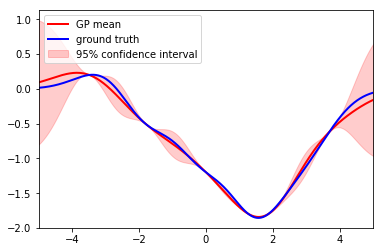

Mean: -1.0730225867124998 , Variance 0.0027616469107452
new sample[[-0.95959596]]


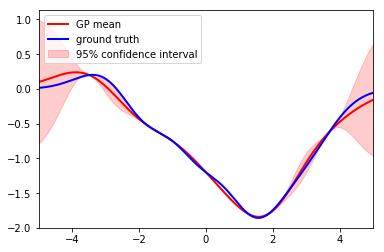

Mean: -1.0692091129438297 , Variance 0.0010895463472394
new sample[[2.27272727]]


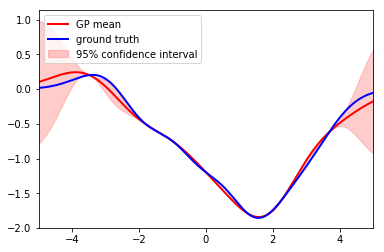

Mean: -1.0668518651397711 , Variance 0.0003690952345221
new sample[[-2.47474747]]


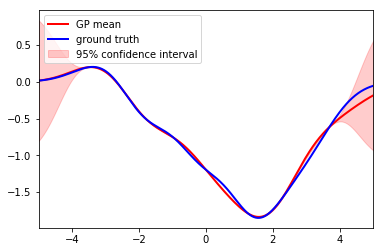

Mean: -1.0611941699135121 , Variance 0.0000714069676862
new sample[[-4.8989899]]


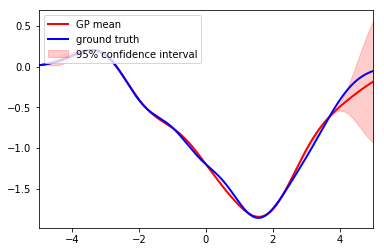

Mean: -1.0612058164143336 , Variance 0.0000370837243256
new sample[[0.45454545]]


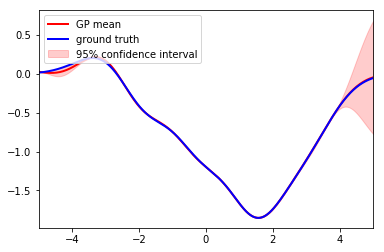

Mean: -1.0564248768052966 , Variance 0.0000172030420044
new sample[[5.]]


KeyboardInterrupt: 

In [11]:
# WITH BAYESIAN QUADRATURE

yy,ee = [],[]
ITERS = 30
zprev = None
x,y,gp = None, None, None
for i in range(ITERS):
    if i>0:
        xs = np.atleast_2d(np.linspace(-5,5,100)).T
        newx = bacquistion(gp,xs,zprev).reshape((1,-1))
        print "new sample" + str(newx)
        x = np.vstack((x, newx))
        y = f(x)
    else:
        x = np.atleast_2d(np.linspace(0,0,1)).T
        y = f(x)
    kernel = RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,optimizer=None)
    gp.fit(x,y)
    plot(gp,f)
    b = np.array([0.0])
    B = np.array([[3.0]])
    u,v,zprev=  bintegrate(gp,b,B)
    print "Mean: %.16f , Variance %.16f" % (u,v)
    yy.append(abs(u-integral_value))
    ee.append(v)


def plot_error(yy,ylabel=''):
    xx = range(ITERS)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(0.0, ITERS+1)
    plt.xlabel('Number of samples')
    plt.ylabel(ylabel)
    plt.show()
print zip(yy,ee)
plot_error(yy,'Integral Mean Error')
plot_error(ee,'Integral Variance')

ITERATION: 0


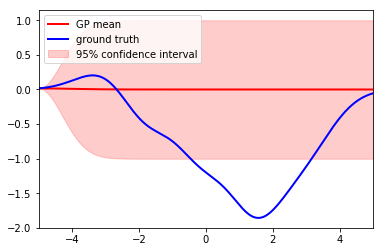

Mean: 0.000344 , Variance 0.3774818594752186
ITERATION: 1


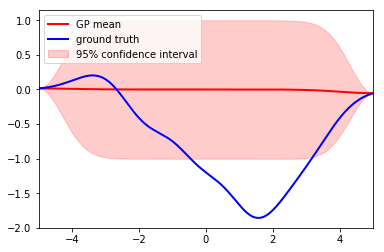

Mean: -0.000829 , Variance 0.3769992459412099
ITERATION: 2


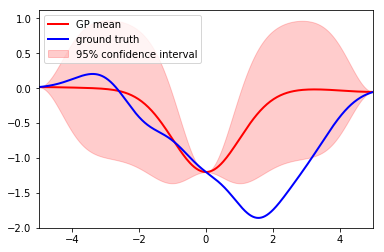

Mean: -0.600267 , Variance 0.1269994096969521
ITERATION: 3


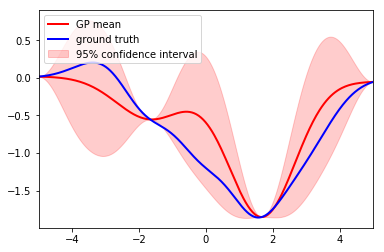

Mean: -0.845385 , Variance 0.1284007128616954
ITERATION: 4


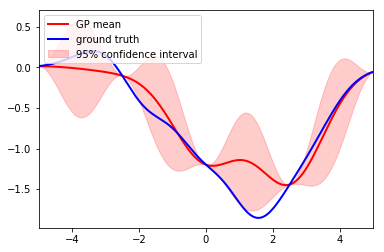

Mean: -0.898465 , Variance 0.0416473703921365
ITERATION: 5


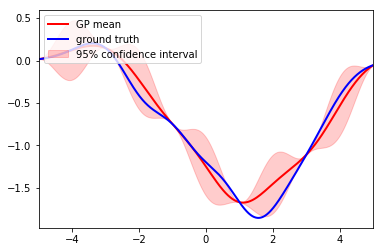

Mean: -1.014439 , Variance 0.0104692326227099
ITERATION: 6


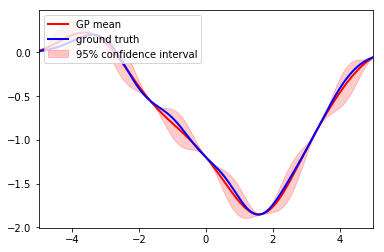

Mean: -1.077527 , Variance 0.0016823711313458
ITERATION: 7


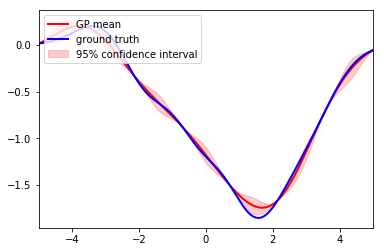

Mean: -1.044500 , Variance 0.0001891496287459
ITERATION: 8


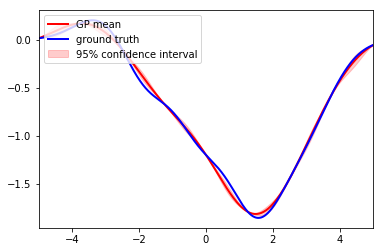

Mean: -1.059094 , Variance 0.0000152707084076
ITERATION: 9


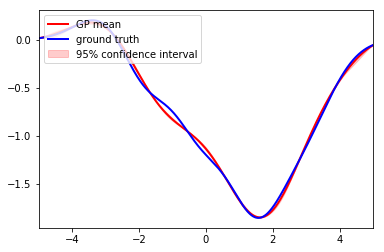

Mean: -1.055778 , Variance 0.0000012126527427
ITERATION: 10


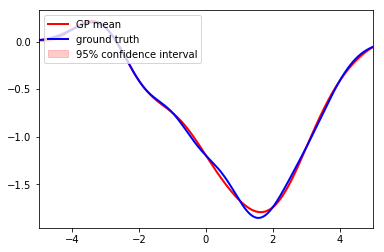

Mean: -1.056209 , Variance 0.0000004449550693
ITERATION: 11


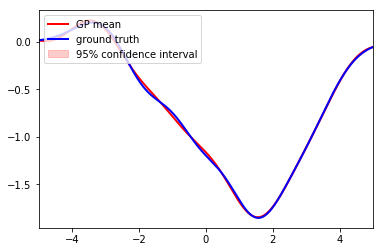

Mean: -1.056183 , Variance 0.0000004290671043
ITERATION: 12


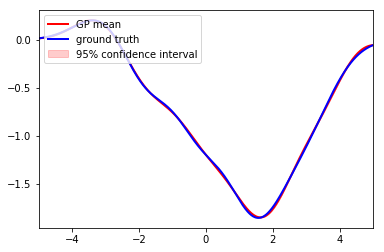

Mean: -1.056276 , Variance 0.0000004146981718
ITERATION: 13


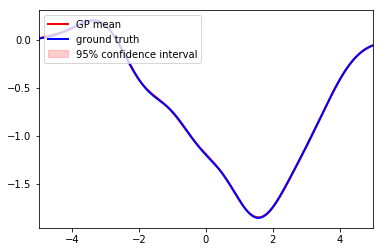

Mean: -1.056286 , Variance 0.0000003944812194
ITERATION: 14


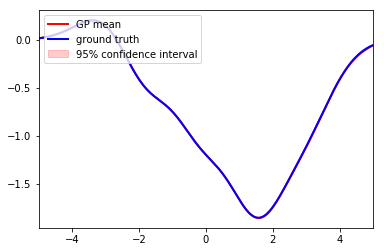

Mean: -1.056183 , Variance 0.0000003507659872
ITERATION: 15


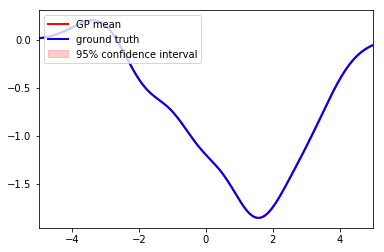

Mean: -1.056164 , Variance 0.0000003185263208
ITERATION: 16


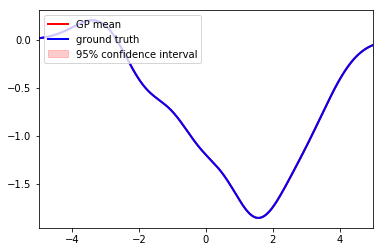

Mean: -1.056219 , Variance 0.0000002668746811
ITERATION: 17


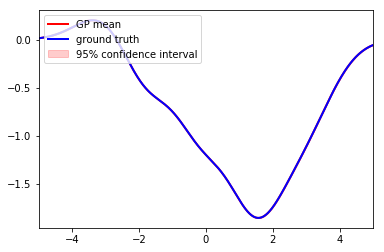

Mean: -1.056231 , Variance 0.0000002366269509
ITERATION: 18


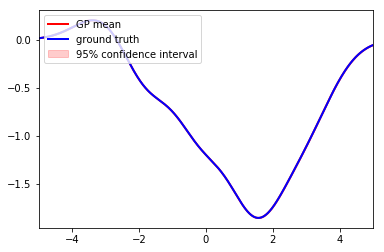

Mean: -1.056214 , Variance 0.0000001894794241
ITERATION: 19


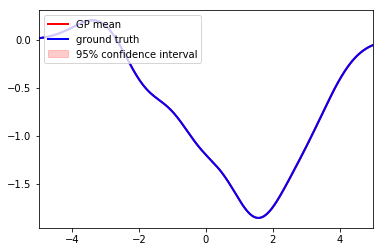

Mean: -1.056211 , Variance 0.0000001660736825
ITERATION: 20


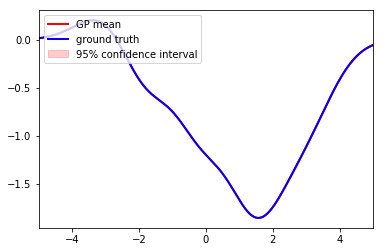

Mean: -1.056214 , Variance 0.0000001282373430
ITERATION: 21


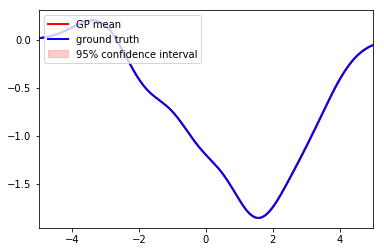

Mean: -1.056214 , Variance 0.0000001118812551
ITERATION: 22


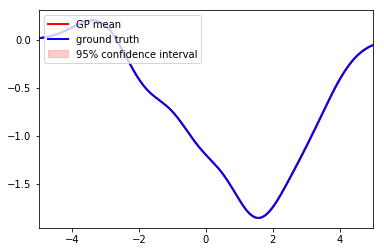

Mean: -1.056214 , Variance 0.0000000839810941
ITERATION: 23


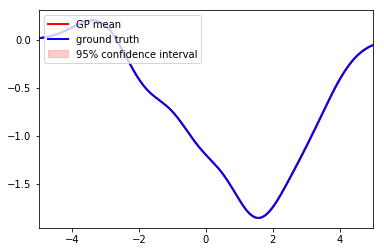

Mean: -1.056214 , Variance 0.0000000731785014
ITERATION: 24


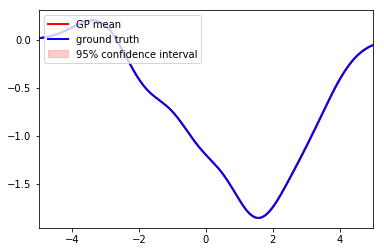

Mean: -1.056214 , Variance 0.0000000564069377
ITERATION: 25


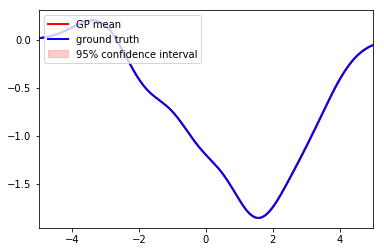

Mean: -1.056214 , Variance 0.0000000482800904
ITERATION: 26


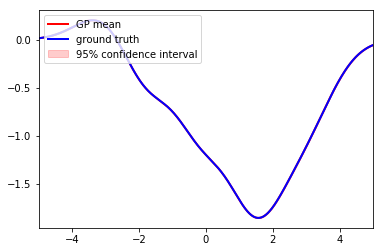

Mean: -1.056214 , Variance 0.0000000423411484
ITERATION: 27


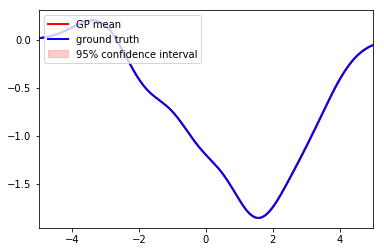

Mean: -1.056214 , Variance 0.0000000374964297
ITERATION: 28


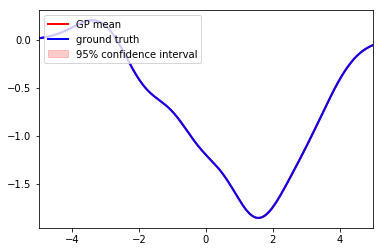

Mean: -1.056214 , Variance 0.0000000334872750
ITERATION: 29


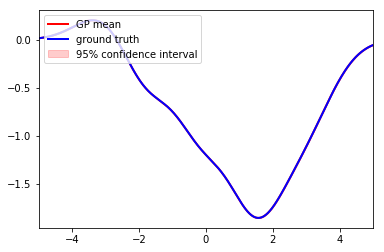

Mean: -1.056214 , Variance 0.0000000301945014
[(1.056557590126058, 0.37748185947521856), (1.0553844249533206, 0.3769992459412099), (0.4559472806961222, 0.12699940969695211), (0.2108293049105774, 0.12840071286169535), (0.15774902733243312, 0.04164737039213651), (0.04177494930064962, 0.010469232622709879), (0.021313424686237425, 0.001682371131345839), (0.011713686755429498, 0.00018914962874594377), (0.0028800612577422058, 1.5270708407566502e-05), (0.00043586778274251614, 1.2126527426659095e-06), (4.718911122303382e-06, 4.4495506928976525e-07), (3.0950609446911415e-05, 4.2906710429058137e-07), (6.26076066658765e-05, 4.1469817180228574e-07), (7.18228906506635e-05, 3.944812193568126e-07), (3.0501341862887443e-05, 3.5076598720040764e-07), (5.029090480990206e-05, 3.1852632081941223e-07), (5.430130749273232e-06, 2.6687468113184565e-07), (1.6833777221947344e-05, 2.3662695092241393e-07), (3.730711344296367e-07, 1.8947942409530683e-07), (2.8655112935815907e-06, 1.6607368252818944e-07), (3.2044470

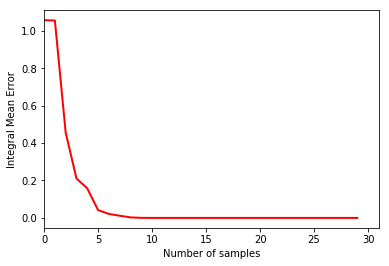

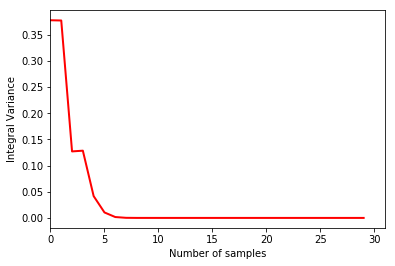

In [10]:
yy,ee = [],[]
ITERS = 30
zprev = None
x,y,gp = None, None, None
for i in range(ITERS):
    print "ITERATION: %d" % i
    x = np.atleast_2d(np.linspace(-5,5,i+1)).T
    y = f(x)
    kernel = RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,optimizer=None)
    gp.fit(x,y)
    plot(gp,f)
    b = np.array([0.0])
    B = np.array([[3.0]])
    u,v,zprev=  bintegrate(gp,b,B)
    print "Mean: %.16f , Variance %.16f" % (u,v)
    yy.append(abs(u-integral_value))
    ee.append(v)


def plot_error(yy,ylabel=''):
    xx = range(ITERS)
    plt.plot(xx, yy, 'r', lw=2)
    plt.xlim(0.0, ITERS+1)
    plt.xlabel('Number of samples')
    plt.ylabel(ylabel)
    plt.show()
print zip(yy,ee)
plot_error(yy,'Integral Mean Error')
plot_error(ee,'Integral Variance')